In [1]:
import numpy as np
import pandas as pd
import os

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
import torchvision.transforms as tt

from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

%matplotlib inline

In [2]:
TRAIN_PATH = "/home/enfycius/Desktop/train_v2/"

In [3]:
train = ImageFolder(TRAIN_PATH, transform = tt.Compose([
    tt.Resize(256),
    tt.ToTensor(),
]))

train_dl = DataLoader(train, 256, shuffle=True, num_workers=3, pin_memory=True)

In [4]:
def get_mean_std(dl):
    sum_, squared_sum, batches = 0, 0, 0
    
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0, 2, 3]))
        squared_sum += torch.mean(data ** 2, dim = ([0, 2, 3]))
        batches += 1
        
    mean = sum_ / batches
    std = (squared_sum / batches - mean ** 2) ** 0.5

    return mean, std

In [5]:
mean, std = get_mean_std(train_dl)

In [6]:
mean, std

(tensor([0.0981, 0.0981, 0.0981]), tensor([0.2759, 0.2759, 0.2759]))

In [7]:
stats = ((0.0696, 0.0696, 0.0696), (0.2366, 0.2366, 0.2366))

In [8]:
train_transform = tt.Compose([
    tt.Resize(256),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

In [9]:
test_transform = tt.Compose([
    tt.Resize(256),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

In [10]:
train = ImageFolder(TRAIN_PATH, transform = train_transform)
test = ImageFolder(TRAIN_PATH, transform = test_transform)

In [11]:
random_seed = 42

In [12]:
torch.manual_seed(random_seed)

In [13]:
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

In [14]:
train_ds, val_ds = random_split(train, [train_size, val_size])

In [15]:
len(train_ds), len(val_ds)

(89, 22)

In [16]:
batch_size = 4

In [17]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size * 2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size * 2, num_workers=2, pin_memory=True)

In [18]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    
    return images * stds + means

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))

        break

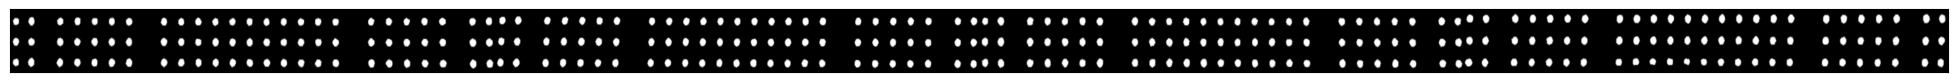

In [20]:
show_batch(train_dl)

In [21]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [22]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [23]:
class BoltDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)            

        loss = F.cross_entropy(out, labels) 

        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    

        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           

        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

In [27]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [28]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

In [31]:
device = get_default_device()

In [32]:
train_dl = BoltDataLoader(train_dl, device)
valid_dl = BoltDataLoader(valid_dl, device)
test_dl = BoltDataLoader(test_dl, device)

In [33]:
num_of_classes = len(train.classes)

In [34]:
num_of_classes

2

# ResNet9

In [35]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    
    if pool: layers.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*layers)

In [36]:
class ResNet9(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        
        return out

In [37]:
model = to_device(ResNet9(3, num_of_classes), device)

In [38]:
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [39]:
history = [evaluate(model, valid_dl)]

In [40]:
history

[{'val_loss': 0.7235816717147827, 'val_acc': 0.236111119389534}]

In [41]:
epochs = 12
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [42]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00201, train_loss: 2.3290, val_loss: 3.6455, val_acc: 0.7639
Epoch [1], last_lr: 0.00595, train_loss: 1.4037, val_loss: 0.5457, val_acc: 0.7639
Epoch [2], last_lr: 0.00934, train_loss: 2.1361, val_loss: 2.5234, val_acc: 0.7639
Epoch [3], last_lr: 0.00994, train_loss: 2.7821, val_loss: 1.7549, val_acc: 0.2361
Epoch [4], last_lr: 0.00933, train_loss: 2.9611, val_loss: 4.4052, val_acc: 0.2361
Epoch [5], last_lr: 0.00812, train_loss: 3.3433, val_loss: 2.0078, val_acc: 0.7639
Epoch [6], last_lr: 0.00647, train_loss: 3.1560, val_loss: 2.5735, val_acc: 0.7639
Epoch [7], last_lr: 0.00463, train_loss: 3.1579, val_loss: 1.0536, val_acc: 0.7639
Epoch [8], last_lr: 0.00283, train_loss: 1.6760, val_loss: 0.7251, val_acc: 0.7639
Epoch [9], last_lr: 0.00133, train_loss: 1.7005, val_loss: 0.4914, val_acc: 0.7639
Epoch [10], last_lr: 0.00035, train_loss: 1.0252, val_loss: 0.8544, val_acc: 0.7639
Epoch [11], last_lr: 0.00000, train_loss: 1.4273, val_loss: 0.8814, val_acc: 0.7639
CP

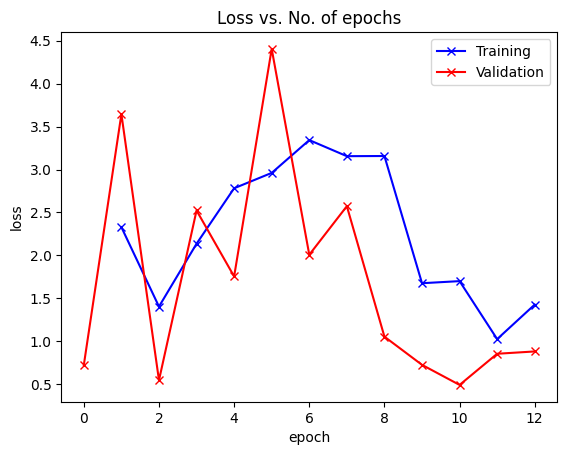

In [43]:
plot_losses(history)

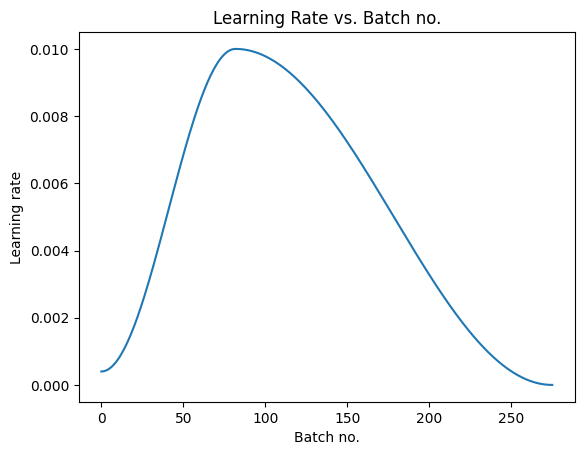

In [44]:
plot_lrs(history)

In [45]:
test_loader = BoltDataLoader(test_dl, device)

In [46]:
result = evaluate(model, test_loader)

In [47]:
result

{'val_loss': 0.9569499492645264, 'val_acc': 0.7410714030265808}

In [48]:
class Convnet(ImageClassification):
    def __init__(self, dropout=0.5):
        super(Convnet, self).__init__()

        self.convnet = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),  # (num_batch, 64, 248, 248)
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 124, 124)

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), # (num_batch, 128, 122, 122)
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 61, 61)

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # (num_batch, 256, 59, 59)
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 256, 29, 29)

          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3), # (num_batch, 128, 27, 27)
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 13, 13)

          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3), # (num_batch, 64, 11, 11)
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 5, 5)
          nn.Flatten() # (num_batch, 1600)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout), 
            nn.Linear(in_features= 184320, out_features=512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=2)
        )
        
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [49]:
del model

# ConvNet

In [50]:
model_v2 = to_device(Convnet(0.2), device)

In [51]:
model_v2

Convnet(
  (convnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, p

In [52]:
epochs = 12
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [53]:
history_v2 = [evaluate(model_v2, valid_dl)]

In [54]:
history_v2

[{'val_loss': 0.7020645141601562, 'val_acc': 0.236111119389534}]

In [55]:
%%time
history_v2 += fit_one_cycle(epochs, max_lr, model_v2, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00201, train_loss: 4.3836, val_loss: 14.6554, val_acc: 0.2361
Epoch [1], last_lr: 0.00595, train_loss: 9.9686, val_loss: 0.7133, val_acc: 0.7639
Epoch [2], last_lr: 0.00934, train_loss: 3.6295, val_loss: 9.9892, val_acc: 0.7639
Epoch [3], last_lr: 0.00994, train_loss: 4.3301, val_loss: 0.6824, val_acc: 0.7639
Epoch [4], last_lr: 0.00933, train_loss: 0.6754, val_loss: 0.5814, val_acc: 0.7639
Epoch [5], last_lr: 0.00812, train_loss: 1.3541, val_loss: 0.5501, val_acc: 0.7639
Epoch [6], last_lr: 0.00647, train_loss: 0.6259, val_loss: 0.5466, val_acc: 0.7639
Epoch [7], last_lr: 0.00463, train_loss: 0.5748, val_loss: 0.5522, val_acc: 0.7639
Epoch [8], last_lr: 0.00283, train_loss: 0.5749, val_loss: 0.5509, val_acc: 0.7639
Epoch [9], last_lr: 0.00133, train_loss: 0.6066, val_loss: 0.5497, val_acc: 0.7639
Epoch [10], last_lr: 0.00035, train_loss: 0.5745, val_loss: 0.5494, val_acc: 0.7639
Epoch [11], last_lr: 0.00000, train_loss: 0.5742, val_loss: 0.5493, val_acc: 0.7639
C

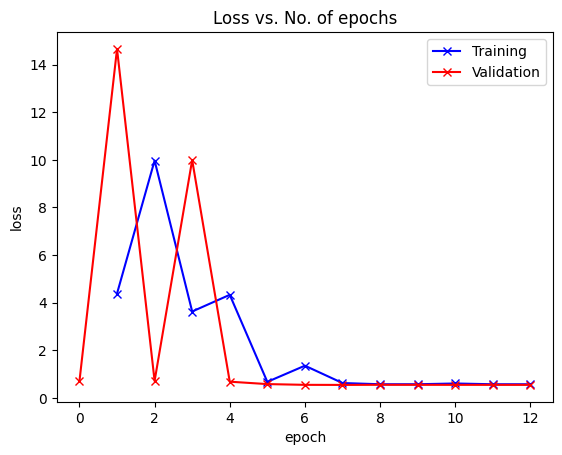

In [56]:
plot_losses(history_v2)

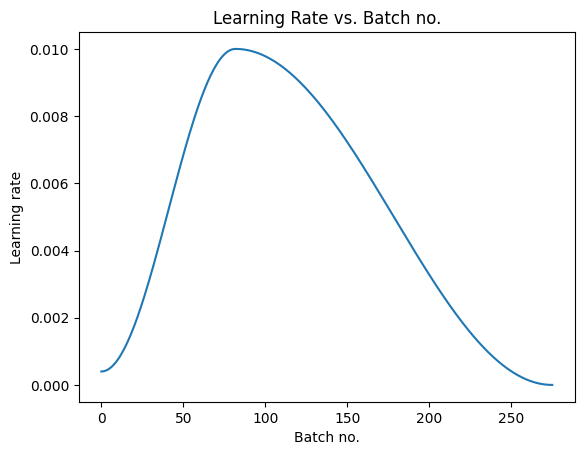

In [57]:
plot_lrs(history_v2)

In [58]:
result_v2 = evaluate(model_v2, test_loader)

In [59]:
result_v2

{'val_loss': 0.5721787214279175, 'val_acc': 0.7410714030265808}

In [60]:
del model_v2